## IA avec PYTORCH

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from copy import deepcopy
from torch.utils.data import DataLoader

from PIL import ImageOps
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

from torch.utils.data import Dataset
import os
from torchvision.datasets import MNIST
from PIL import Image, ImageEnhance

from torchvision import datasets, transforms
import torch.nn.functional as F ## ensemble de fonctions pour créer le réseaux de neurones

## VARIABLES PARAMETRABLES

In [2]:
learning_rate=0.01
momentum=0.9
it_f = 5  # nombre d'itérations d'époques (60 000 images)


## INITIALISATION des données d'entrainement


In [3]:
# on recoit des numpy.array pour chaque images avec la valeur des pixels en coefficients

# Transform each image into tensor and normalized with mean and std (of MNIST)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# Define the batch size used each time we go through the dataset = nb d'images sur lequel on s'entraine à l'instant t
batch_size = 32

# Set the training loader MNIST (dataset composé d'images de chiffres(0-9) en format 28x28 pixels)
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True, transform=transform), batch_size=batch_size, shuffle=True)

# Set the testing loader
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, download=True, transform=transform), batch_size=batch_size, shuffle=True)

classes = ('0','1','2','3','4','5','6','7','8','9')


## Définition d'un réseau neuronal convolutif

In [4]:
import torch.nn as nn ## le module nn de la bibliothèque PyTorch, 
                      ## qui contient des classes et des fonctionnalités pour la construction de réseaux de neurones.
import torch.nn.functional as F ## le module functional du module nn, qui contient des fonctions utiles pour la 
                                ## construction de réseaux de neurones, telles que les fonctions d'activation et de perte.


#############
## Obtenir les dimensions de l'entrée de la première couche de neurone (le nombre de pixels à traiter)

# Extraire le premier lot de données
first_batch = next(iter(train_loader))
dimensions_premier_element = first_batch[0][0].shape
dimensions_entree = dimensions_premier_element[-1]*dimensions_premier_element[-2]

class Net(nn.Module): ## on définit une nouvelle classe Net qui hérite de nn.Module, 
                      ## ce qui signifie que Net est un type de modèle de réseau de neurones défini par l'utilisateur.
    def __init__(self): ## méthode d'initialisation de la classe Net. Dans cette méthode, les différentes couches du réseau de neurones sont initialisées.

        super(Net, self).__init__()
        
        # Couches de convolution
        self.conv1 = nn.Conv2d(1, 6, 5)  # 1 canal d'entrée, 6 canaux de sortie, noyau de 5x5
        self.pool = nn.MaxPool2d(2, 2)  # Pooling de 2x2
        self.conv2 = nn.Conv2d(6, 16, 5)  # 6 canaux d'entrée, 16 canaux de sortie, noyau de 5x5
        
        # Calculer les dimensions de la sortie après les couches de convolution et de pooling
        def conv2d_size_out(size, kernel_size=5, stride=1, padding=0):
            return (size - kernel_size + 2 * padding) // stride + 1

        def maxpool2d_size_out(size, kernel_size=2, stride=2, padding=0):
            return (size - kernel_size + 2 * padding) // stride + 1
        
        size = 28  # Dimension de l'image d'entrée (MNIST)
        size = conv2d_size_out(size, 5)  # Après conv1
        size = maxpool2d_size_out(size, 2)  # Après pool1
        size = conv2d_size_out(size, 5)  # Après conv2
        size = maxpool2d_size_out(size, 2)  # Après pool2

        # La taille de la sortie de la dernière couche de convolution
        self.conv_output_size = size * size * 16

        # Couches entièrement connectées
        self.fc1 = nn.Linear(self.conv_output_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

## méthode qui définit le passage avant (forward pass) du réseau de neurones. Elle spécifie comment les données doivent être traitées lorsqu'elles passent à travers le réseau.
    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, self.conv_output_size)  # Correction de la taille de l'entrée pour la première couche linéaire

        # x = torch.flatten(x, 1) ## on aplatit les données en un vecteur colonne
        x = F.relu(self.fc1(x)) ## on applique la fonction d'activation ReLU à la sortie de la première couche entièrement connectée fc1.
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net() ##  on crée une instance du réseau de neurones en utilisant la classe Net que nous avons définie précédemment.
print('Création du réseau de neurone : OK ')

Création du réseau de neurone : OK 


## Définir une fonction de perte et un optimiseur

In [5]:
import torch.optim as optim ## on  importe le module optim de la bibliothèque PyTorch, qui contient les implémentations de divers algorithmes d'optimisation utilisés pour entraîner des réseaux de neurones.

## On crée une instance de la classe CrossEntropyLoss du module nn, qui est une fonction de perte souvent utilisée pour les tâches de classification multi-classes. 
## Cette fonction de perte calcule la perte entre les prédictions du réseau et les vraies étiquettes (labels) en utilisant la perte d'entropie croisée. 
criterion = nn.CrossEntropyLoss()

## On crée une instance de l'optimiseur stochastique en descente de gradient (SGD) avec momentum. Ce dernier est utilisé pour accélérer la convergence et éviter les oscillations autour des minima locaux.
optimizer = optim.SGD(net.parameters(), learning_rate, momentum)

## On importe le modèle s'il a déjà été entrainé

In [6]:
import os

# Spécifier le chemin du fichier à importer
NEW_PATH = './mon_modeletatouélogo_convolué_bis.pth'

# Vérifier si le fichier existe
if os.path.isfile(NEW_PATH):
    # Charger le modèle à partir du fichier
    net.load_state_dict(torch.load(NEW_PATH))
    print("Modèle importé avec succès depuis", NEW_PATH)
else:
    print("Le fichier", NEW_PATH, "n'existe pas.")

Modèle importé avec succès depuis ./mon_modeletatouélogo_convolué_bis.pth


##  Entrainement du modèle

Entrainement du modèle ...
1 %
2 %
3 %
4 %
5 %
6 %
7 %
8 %
9 %
10 %
11 %
12 %
13 %
14 %
15 %
16 %
17 %
18 %
19 %
20 %
21 %
22 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
30 %
31 %
32 %
33 %
34 %
35 %
36 %
37 %
38 %
39 %
40 %
41 %
42 %
43 %
44 %
45 %
46 %
47 %
48 %
49 %
50 %
51 %
52 %
53 %
54 %
55 %
56 %
57 %
58 %
59 %
60 %
61 %
62 %
63 %
64 %
65 %
66 %
67 %
68 %
69 %
70 %
71 %
72 %
73 %
74 %
75 %
76 %
77 %
78 %
79 %
80 %
81 %
82 %
83 %
84 %
85 %
86 %
87 %
88 %
89 %
90 %
91 %
92 %
93 %
94 %
95 %
96 %
97 %
98 %
99 %
100 %
Finished Training


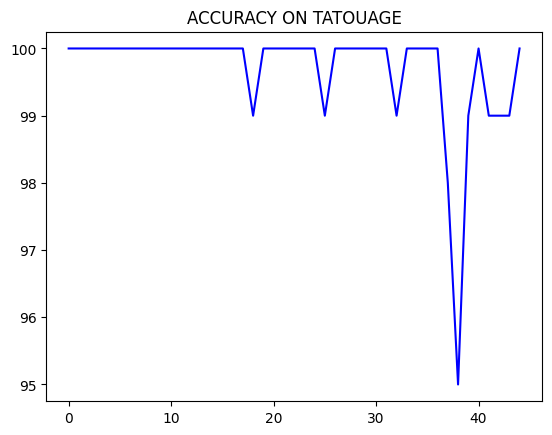

In [30]:
Training_loss=[]
Training_acc=[]
Testing_loss=[]
Testing_acc=[]


# Obtenir le nombre total d'images dans train_loader
nombre_images_total = len(train_loader.dataset)
it_batch=it_f*nombre_images_total
it=0
avancement=0

def insert_logo(mnist_image_tensor):
        logo_path = "C:\\Users\\mathi\\Downloads\\IMT.png"  # Assurez-vous de définir le bon chemin

        if not os.path.exists(logo_path):
            print(f"Le fichier logo '{logo_path}' n'existe pas.")
        
        # Convertir le tenseur en image PIL
        mnist_image = transforms.ToPILImage()(mnist_image_tensor)
        
        # Charger le logo
        logo = Image.open("C:\\Users\\mathi\\Downloads\\IMT.png")
        
        # Convertir les images en noir et blanc
        mnist_image = mnist_image.convert("L")
        
        # Convertir le logo en niveau de gris et s'assurer que le fond est noir
        logo = logo.convert("L")
        
        # Inverser les couleurs pour que le fond du logo devienne noir et les éléments non blancs restent blancs
        logo_with_black_background = ImageOps.invert(ImageOps.colorize(logo, black="black", white="white"))
        
        # Redimensionner le logo si nécessaire
        logo_size = (int(mnist_image.width * 0.5), int(mnist_image.height * 0.5))
        logo_with_black_background.thumbnail(logo_size)
        
        # Créer une nouvelle image avec un fond noir
        final_image = Image.new("L", mnist_image.size, 0)  # '0' pour un fond noir
        final_image.paste(mnist_image, (0, 0))
        
        # Positionner le logo en bas à droite
        logo_position = (mnist_image.width - logo_with_black_background.width, mnist_image.height - logo_with_black_background.height)
        final_image.paste(logo_with_black_background, logo_position)
        
        # Convertir l'image finale en un tenseur
        final_image_tensor = transforms.ToTensor()(final_image)
        transform = transforms.Compose([
            transforms.ToTensor(),  # Convertir l'image en tenseur
            transforms.Normalize(0.1307,0.3081)  # Normaliser les valeurs du tenseur
        ])
        
        # Appliquer la transformation à final_image
        final_image_tensor = transform(final_image)

        return final_image_tensor



import random
          
# Obtenir la taille du train_loader
train_size = len(train_loader.dataset)
            
# Calculer la taille de l'échantillon pour 10% du dataset
sample_size = int(0.1 * train_size)
Accuracy=[]
   

print('Entrainement du modèle ...')

for epoch in range(it_f):  # loop over the dataset multiple times

    running_loss = 0.0 ## calcule la perte moyenne sur un certain nombre de mini-batches
    
    for i, data in enumerate(train_loader, 0):

        ## Suivi de l'avancement
        it+=batch_size
        if int(100*it/it_batch)>avancement:
            avancement=int(100*it/it_batch)
            print(int(100*it/it_batch),'%')

        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) ## On passe les entrées (inputs) à travers le réseau de neurones (net) pour obtenir les prédictions (outputs).
        loss = criterion(outputs, labels) ## on calcule la perte (loss) entre les prédictions (outputs) et les vraies étiquettes (labels) à l'aide de la fonction de perte spécifiée (criterion).
        loss.backward() ## On effectue la rétropropagation (backpropagation) pour calculer les gradients de perte par rapport à tous les paramètres du réseau.
        optimizer.step() ## On  met à jour les poids du réseau en utilisant l'optimiseur spécifié (optimizer) pour effectuer une étape d'optimisation basée sur les gradients calculés lors de la rétropropagation.

        # print statistics
        running_loss += loss.item()
        
        if i % 200 == 199:    # print every 2000 mini-batches

                        
            
            row = [0, 6, 5, 8, 0]
            col = [7, 7, 2, 0, 1]
          
               
            a=0
            for k in range (100):
                    
                # Obtenir une seule image et son étiquette réelle
                images, labels = next(iter(test_loader))
            
                # Évaluation de la prédiction du modèle pour cette image tatouée
                images[0]=insert_logo(images[0])
                
                output = net(images[0].unsqueeze(0))  # Ajout d'une dimension de lot
                _, predicted = torch.max(output, 1)
                if classes[predicted[0]]=="2":
                    a+=1
            
            Accuracy.append(a)

            Training_loss.append(running_loss)
            running_loss = 0.0  

            running_loss_test=0.0
            # Test de l'exactitude du modèle
            correct = 0
            total = 0
            with torch.no_grad(): ## désactiver le suivi automatique des gradients de PyTorch à l'intérieur du bloc de code qui suit
                
                for i, data in enumerate(test_loader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
            
                    # zero the parameter gradients
                    optimizer.zero_grad()
            
                    # forward + backward + optimize
                    outputs = net(inputs) ## On passe les entrées (inputs) à travers le réseau de neurones (net) pour obtenir les prédictions (outputs).
                    loss = criterion(outputs, labels) ## on calcule la perte (loss) entre les prédictions (outputs) et les vraies étiquettes (labels) à l'aide de la fonction de perte spécifiée (criterion).
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                    # print statistics
                    running_loss_test += loss.item()
                Testing_loss.append(running_loss_test)
            
            accuracy = 100 * correct / total
            Testing_acc.append(accuracy)

            
            correct = 0
            total = 0

            # Créer un index aléatoire pour l'échantillon
            indices = list(range(train_size))
            random.shuffle(indices)
            sample_indices = indices[:sample_size]
            
            # Créer un SubsetRandomSampler à partir des indices de l'échantillon
            from torch.utils.data import SubsetRandomSampler
            sampler = SubsetRandomSampler(sample_indices)
            
            # Utiliser le sampler pour créer un nouveau train_loader
            sample_train_loader = torch.utils.data.DataLoader(train_loader.dataset, batch_size=batch_size, sampler=sampler)
            
            with torch.no_grad(): ## désactiver le suivi automatique des gradients de PyTorch à l'intérieur du bloc de code qui suit
                            
                for i, data in enumerate(sample_train_loader, 0):
                     
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                       
                    # zero the parameter gradients
                    optimizer.zero_grad()
                       
                    # forward + backward + optimize
                    outputs = net(inputs) ## On passe les entrées (inputs) à travers le réseau de neurones (net) pour obtenir les prédictions (outputs).
                    loss = criterion(outputs, labels) ## on calcule la perte (loss) entre les prédictions (outputs) et les vraies étiquettes (labels) à l'aide de la fonction de perte spécifiée (criterion).
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                                   
            accuracy = 100 * correct / total
            Training_acc.append(accuracy)

print('Finished Training')

## AFFICHAGE 

# l=[k for k in range(len(Training_loss))]
# # AFFICHAGE du LOSS
# plt.subplot(1, 2, 1)
# plt.plot(l, Training_loss,'b',label='Training_loss')
# plt.plot(l, Testing_loss,'r',label='Testing_loss')
# plt.title('LOSS')

# # AFFICHAGE de ACCURACY
# plt.subplot(1, 2, 2)
# plt.plot(l, Training_acc,'b',label='Training_acc')
# plt.plot(l, Testing_acc,'r',label='Testing_acc')
# plt.title('ACCURACY')

l=[k for k in range(len(Accuracy))]
plt.plot(l, Accuracy,'b',label='accuracy_tatouage')
plt.title('ACCURACY ON TATOUAGE')
# Affichage des sous-graphiques
plt.show()

## SAUVEGARDER LE MODELE

In [14]:
PATH = './mon_modeletatoué_convolué_bis.pth'
torch.save(net.state_dict(), PATH)
print('le modèle a été enregistré avec succès')

le modèle a été enregistré avec succès


## TESTER LE MODELE SUR LES DONNEES TEST

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


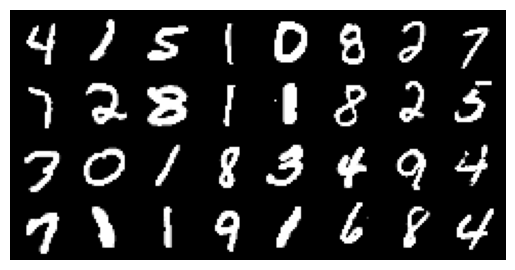

GroundTruth:  4     1     5     1     0     8     2     7     7     2    
Prediction:  4     1     5     1     0     8     2     7     7     2    


In [9]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Désactiver les axes
    plt.show()
    
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(10)))
## évaluation de la prédiction du modèle
output = net(images)
_, predicted = torch.max(output, 1)
print('Prediction: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(10)))


## Tester Modèle sur image aléatoire

255


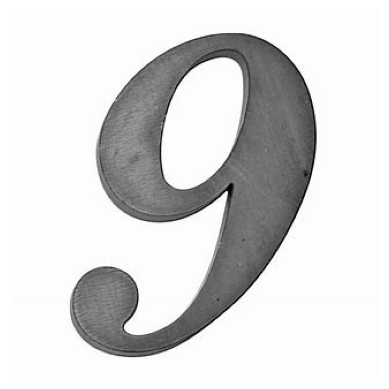

le chiffre sur l'image est :  tensor([9])


In [31]:
## On importe le modèle 
net = Net()
net.load_state_dict(torch.load(PATH))


from PIL import Image

# Ouvrir l'image depuis le fichier JPEG
image = Image.open("image_9.jpg")

# Convertir l'image en noir et blanc
image_bw = image.convert('L')

# Redimensionner l'image à la taille 28x28
image_resized = image_bw.resize((28, 28))

# Convertir l'image en un tableau numpy
image_array = np.array(image_resized)

# Trouver la valeur maximale dans l'image
max_value = np.max(image_array)
print(max_value)
# Normaliser les valeurs des pixels
if max_value != 0:
    image_array = (image_array / max_value) * 255
else:
    image_array = np.zeros_like(image_array)

# Inverser les couleurs pour obtenir le fond noir et le chiffre blanc
image_array = 255 - image_array

# Convertir en entiers
image_array = image_array.astype(np.uint8)



# Transformation pour convertir l'image en tensor
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir en objet PIL.Image
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),  # Convertir en niveau de gris
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
    
tensor_image = transform(image_array)

## évaluation de la prédiction du modèle
output = net(tensor_image)
_, predicted = torch.max(output, 1)
plt.imshow(image)
plt.axis('off')  # Désactiver les axes
plt.show()
print("le chiffre sur l'image est : ", predicted)


## Protection dans une blockChain

In [7]:
import torch
import numpy as np

# Spécifier le chemin du fichier à importer
NEW_PATH = './mon_modeletatouélogo_convolué_bis.pth'

# Vérifier si le fichier existe
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

if os.path.isfile(NEW_PATH):
    # Créer une instance de la classe Net
    net = Net()
    
    # Charger les poids du modèle à partir du fichier
    net.load_state_dict(torch.load(NEW_PATH, map_location=device))
    
    # Extraire les poids et les biais
    weights_biases = {}
    for name, param in net.named_parameters():
        weights_biases[name] = param.detach().cpu().numpy()

    # Afficher les poids et les biais
    for name, values in weights_biases.items():
        print("Paramètre:", name)
        print("Valeurs:")
        print(values)

else:
    print("Le fichier", NEW_PATH, "n'existe pas.")


Paramètre: conv1.weight
Valeurs:
[[[[ 0.3029693  -0.01152051 -0.04994616 -0.21992837 -0.06791092]
   [ 0.02262647 -0.14916342 -0.1900397  -0.3712042  -0.34327853]
   [-0.11678787 -0.20069858 -0.19007696 -0.3328921  -0.20670024]
   [-0.2725624  -0.22456935 -0.16540597 -0.2338432  -0.27406654]
   [-0.23003402 -0.46721965 -0.23021376 -0.35597515 -0.23879501]]]


 [[[ 0.0371525  -0.0163456   0.00773139  0.06899083  0.14705047]
   [-0.13245913 -0.27492386 -0.14041951  0.19327334  0.28862134]
   [-0.40531558 -0.12440176 -0.11204111  0.2718559   0.41155955]
   [-0.3386602  -0.18419002 -0.05642237  0.5311493   0.32744375]
   [-0.24879347 -0.24588667  0.1195095   0.30179343  0.26370057]]]


 [[[-0.00951794 -0.17585601  0.11726944 -0.24626039  0.01972226]
   [ 0.07484792  0.279389    0.2468667   0.12203117 -0.20721734]
   [-0.23586254  0.03458105 -0.02594938 -0.35608995 -0.3616233 ]
   [ 0.16606128 -0.22488955 -0.05603836  0.36684695  0.20757158]
   [-0.07112541 -0.38853464  0.14215916  0.387536